In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
from rasterstats import zonal_stats

plt.style.use("ggplot")

In [2]:
# Connect to the 'general' database as a 'read-only' user
eng = nivapy.da.connect_postgis()

Connection successful.


# Summary statistics for major Tana subcatchments

## 1. Site locations

In [3]:
# Lat/lon co-ords from NVE Atlas
xl_path = "../data/subcatchments_metadata/tana_major_subcatchments.xlsx"
df = pd.read_excel(xl_path)
df.head()

,site_id,site_name,lat,lon
0,M4,Anarjohka,69.39845,25.84344
1,M2,Iesjakka,69.42579,24.94077
2,M5,Karasjohka,69.39736,25.14364


## 2. Derive catchment boundaries

In [4]:
gdf = nivapy.spatial.derive_watershed_boundaries(
    df,
    id_col="site_id",
    xcol="lon",
    ycol="lat",
    crs="epsg:4326",
    min_size_km2=100,
    dem_res_m=10,
    buffer_km=None,
    temp_fold=None,
    reproject=False,
)
gdf["catch_area_km2"] = gdf.geometry.area / 1e6
gdf.head()

Connection successful.


Looping over vassdragsområder:   0%|          | 0/1 [00:00<?, ?it/s]

Looping over outlets in vassdragsområder 234:   0%|          | 0/3 [00:00<?, ?it/s]

,site_id,geometry,site_name,lat,lon,catch_area_km2
0,M2,"MULTIPOLYGON (((864860.000 7702110.000, 864860...",Iesjakka,69.42579,24.94077,2081.5829
1,M4,"MULTIPOLYGON (((942470.000 7749590.000, 942480...",Anarjohka,69.39845,25.84344,3087.5113
2,M5,"MULTIPOLYGON (((865460.000 7656900.000, 865470...",Karasjohka,69.39736,25.14364,2230.3428


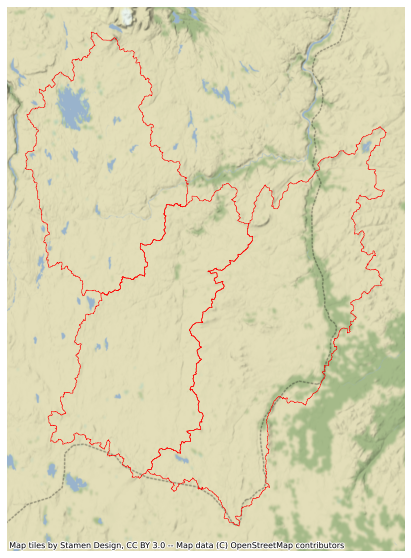

In [5]:
# Plot
ax = gdf.plot(figsize=(10, 10), edgecolor="r", facecolor="none")
cx.add_basemap(ax, crs=gdf.crs, source=cx.providers.Stamen.Terrain)
ax.set_axis_off()

In [6]:
out_shp = r"../output/gis/tana_main_subcatchments.shp"
gdf.to_file(out_shp)

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_1915/1461212871.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(out_shp)


## 3. Land cover

### 3.1. AR50

In [7]:
ar50_gdf = nivapy.da.read_postgis(
    "physical",
    "norway_nibio_ar50_poly",
    eng,
    clip=gdf,
)

# Intersect
ar50_gdf = gpd.overlay(ar50_gdf, gdf, how="intersection")
ar50_gdf = ar50_gdf.dissolve(by=["description", "site_id"], as_index=False)
ar50_gdf["area_km2"] = ar50_gdf.geometry.area / 1e6
ar50_gdf["land_cover_pct"] = 100 * ar50_gdf["area_km2"] / ar50_gdf["catch_area_km2"]
ar50_gdf = ar50_gdf.sort_values("site_id").reset_index()

ar50_gdf[['site_id', 'description', 'area_km2', 'land_cover_pct']]

,site_id,description,area_km2,land_cover_pct
0,M2,Ferskvann: Elv og innsjø,209.632881,10.070840
1,M2,Snaumark: Fastmark med naturlig vegetasjonsdek...,974.528711,46.816714
2,M2,Skog: Skogdekt areal,661.951365,31.800384
3,M2,"Jordbruk: Fulldyrka jord, overflatedyrka jord ...",0.573222,0.027538
4,M2,Myr: Areal som på overflata har preg av myr,234.896721,11.284524
5,M4,Ikke kartlagt,0.130262,0.004219
6,M4,"Jordbruk: Fulldyrka jord, overflatedyrka jord ...",0.550068,0.017816
7,M4,Snaumark: Fastmark med naturlig vegetasjonsdek...,327.950814,10.621850
8,M4,Myr: Areal som på overflata har preg av myr,374.600844,12.132776
9,M4,Skog: Skogdekt areal,1446.358112,46.845435


<AxesSubplot:>

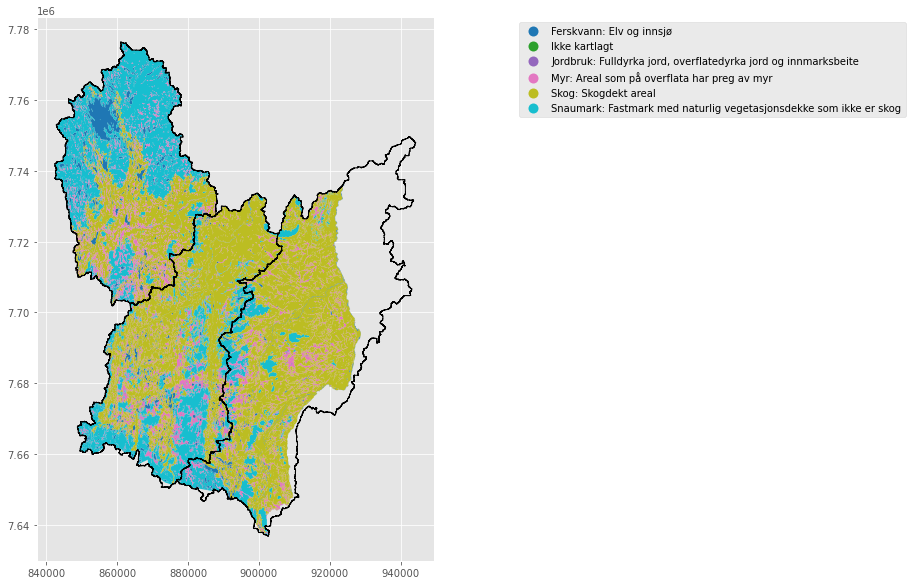

In [8]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ar50_gdf.plot(
    column="description",
    legend=True,
    legend_kwds={"bbox_to_anchor": (2.2, 1)},
    ax=ax,
)

gdf.plot(edgecolor="k", facecolor="none", ax=ax, lw=1)

### 3.2. Corine 2018

In [9]:
cor18_gdf = nivapy.da.read_postgis(
    "physical",
    "norway_nibio_corine_2018_poly",
    eng,
    clip=gdf,
)

# Intersect
cor18_gdf = gpd.overlay(cor18_gdf, gdf, how="intersection")
cor18_gdf = cor18_gdf.dissolve(by=["english", "site_id"], as_index=False)
cor18_gdf["area_km2"] = cor18_gdf.geometry.area / 1e6
cor18_gdf["land_cover_pct"] = 100 * cor18_gdf["area_km2"] / cor18_gdf["catch_area_km2"]
cor18_gdf = cor18_gdf.sort_values("site_id").reset_index()

cor18_gdf[['site_id', 'english', 'area_km2', 'land_cover_pct']]

Converting to the projection of target dataset (epsg:32633)


/tmp/ipykernel_1915/1179685266.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32633
Right CRS: EPSG:25833

  cor18_gdf = gpd.overlay(cor18_gdf, gdf, how="intersection")


,site_id,english,area_km2,land_cover_pct
0,M2,Bare rock,1.112635,0.053451
1,M2,Broad-leaved forest,633.951893,30.455280
2,M2,Peat bogs,256.377933,12.316489
3,M2,Water courses,0.788042,0.037858
4,M2,Coniferous forest,0.396998,0.019072
5,M2,Water bodies,162.007087,7.782879
6,M2,Moors and heath land,208.945805,10.037833
7,M2,"Land principally occupied by agriculture, with...",0.363382,0.017457
8,M2,Sparsely vegetated areas,816.297524,39.215230
9,M2,Mixed forest,1.341602,0.064451


<AxesSubplot:>

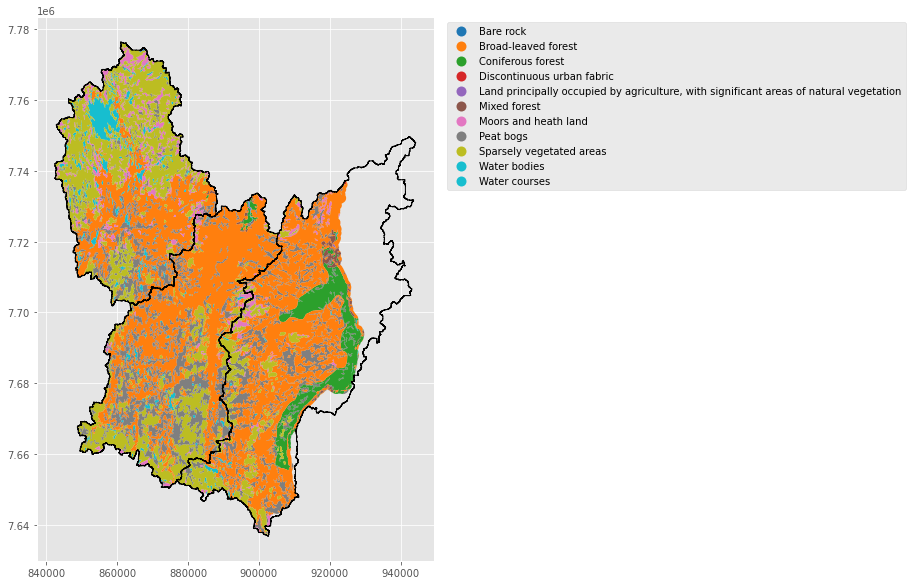

In [10]:
# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

cor18_gdf.plot(
    column="english",
    legend=True,
    legend_kwds={"bbox_to_anchor": (2.2, 1)},
    ax=ax,
)

gdf.plot(edgecolor="k", facecolor="none", ax=ax, lw=1)

## 4. Elevation statistics

In [11]:
ras_path = r"/home/jovyan/shared/01_datasets/spatial/dtm_merged_utm33/dtm_10m/by_vassom/dtm/vassom_234_10m_dtm.tif"
stats_df = gdf.join(
    pd.DataFrame(
        zonal_stats(
            vectors=gdf["geometry"],
            raster=ras_path,
            stats=["count", "min", "mean", "max", "median"],
        )
    ),
    how="left",
)
stats_df

,site_id,geometry,site_name,lat,lon,catch_area_km2,min,max,mean,count,median
0,M2,"MULTIPOLYGON (((864860.000 7702110.000, 864860...",Iesjakka,69.42579,24.94077,2081.5829,182.114990,1021.851746,417.294496,20815829,413.505066
1,M4,"MULTIPOLYGON (((942470.000 7749590.000, 942480...",Anarjohka,69.39845,25.84344,3087.5113,117.736885,641.816101,334.770095,30875113,331.057343
2,M5,"MULTIPOLYGON (((865460.000 7656900.000, 865470...",Karasjohka,69.39736,25.14364,2230.3428,139.070648,618.453247,383.779277,22303428,386.781097
